In [76]:
import string
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [77]:
def preprocess(file_path):
    """
    Preprocess the raw text in the specified file.
    
    Parameters:
    - file_path (str): Path to the raw text file.
    
    Returns:
    - list: List of preprocessed words.
    """
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        text = file.read()
        
        # Separate words by white spaces
        words = text.split()
        
        # Convert to lowercase and remove punctuation including explicit double quotes
        punctuations = string.punctuation + '“”‘’'  # Adding typographic quotes
        table = str.maketrans("", "", punctuations)
        preprocessed_words = [word.lower().translate(table) for word in words]
        
    return preprocessed_words


def compute_B(words, N=200):
    """
    Compute the set B of the top N high-frequency words.
    
    Parameters:
    - words (list): List of preprocessed words from the corpus.
    - N (int): Number of top words to select. Default is 200.
    
    Returns:
    - list: List of top N high-frequency words.
    """
    
    # Count word frequencies
    word_freq = Counter(words)
    
    # Get the top N words
    top_words = [word for word, _ in word_freq.most_common(N)]
    
    return top_words

def compute_T(words, B_size=200, T_size=100):
    """
    Compute the set T of words that come after the top B_size high-frequency words.
    
    Parameters:
    - words (list): List of preprocessed words from the corpus.
    - B_size (int): Number of top words that were selected for B. Default is 200.
    - T_size (int): Number of words to select for T. Default is 100.
    
    Returns:
    - list: List of T_size words that come after the top B_size words.
    """
    
    # Count word frequencies
    word_freq = Counter(words)
    
    # Get words after the top B_size words
    T_words = [word for word, _ in word_freq.most_common(B_size + T_size)][B_size:]
    
    return T_words

def compute_T_(text, B_words, num_words=50, after_top_B=500):
    """
    Compute the set T by selecting the top occurring words after excluding B_words.
    
    Parameters:
    - text: A list of words from the book.
    - B_words: List of words in B.
    - num_words: Number of words to select for T.
    - after_top_B: Sample words from the top x words after B_words.
    
    Returns:
    - List of words for T.
    """
    from collections import Counter
    import random

    # Calculate word frequencies
    word_freqs = Counter(text)

    # Remove B_words from the frequency list
    for word in B_words:
        word_freqs.pop(word, None)

    # Sort words by frequency and select the top (after_top_B) words
    top_words = [word for word, freq in word_freqs.most_common(after_top_B)]
    
    # Randomly sample (num_words) from the top words
    T_words = random.sample(top_words, num_words)

    return T_words

def compute_cooccurrence_matrix(words, T, B, window_size=5):
    """
    Compute the co-occurrence matrix for words in T and context words in B.
    
    Parameters:
    - words (list): List of preprocessed words from the corpus.
    - T (list): Target words.
    - B (list): Context words.
    - window_size (int): Size of the context window. Default is 5.
    
    Returns:
    - numpy.array: Co-occurrence matrix of size len(T) x len(B).
    """
    
    # Initialize co-occurrence matrix with zeros
    cooccurrence_matrix = np.zeros((len(T), len(B)))
    
    half_window = window_size // 2
    
    for i in range(len(words)):
        if words[i] in T:
            # Get the window around the target word
            start_index = max(0, i - half_window)
            end_index = min(len(words), i + half_window + 1)
            
            # Get the context words in the window
            context = words[start_index:i] + words[i+1:end_index]
            
            # Update the co-occurrence matrix
            for w in context:
                if w in B:
                    cooccurrence_matrix[T.index(words[i])][B.index(w)] += 1
                    
    return cooccurrence_matrix

def compute_ppmi(matrix):
    """
    Compute the Positive Pointwise Mutual Information (PPMI) matrix from the co-occurrence matrix.
    
    Parameters:
    - matrix (numpy.array): Co-occurrence matrix.
    
    Returns:
    - numpy.array: PPMI matrix.
    """
    # Calculate the sums for each word and the total co-occurrences
    row_sums = np.sum(matrix, axis=1)
    col_sums = np.sum(matrix, axis=0)
    total = np.sum(matrix)
    
    # Calculate the expected co-occurrences if the words were independent
    expected = np.outer(row_sums, col_sums) / total
    
    # Compute the ratio
    ratio = matrix * total / (expected + 1e-8)
    
    # Apply the logarithm where the ratio is non-zero
    with np.errstate(divide='ignore'):
        ppmi_vals = np.log2(ratio)
    ppmi_vals[np.isnan(ppmi_vals)] = 0
    ppmi_vals[np.isinf(ppmi_vals)] = 0
    ppmi_vals = np.maximum(ppmi_vals, 0)  # Keep only the positive values
    
    return ppmi_vals


def plot_pca(data, labels):
    """
    Apply PCA on the data and plot the results.
    
    Parameters:
    - data (numpy.array): The data matrix to apply PCA on.
    - labels (list): The labels (in this case, words) for each data point.
    """
    # Apply PCA and transform the data to 2D
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    
    # Plot the transformed data
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    xs = pca_data[:, 0]  # first component
    ys = pca_data[:, 1]  # second component
    ax.scatter(xs, ys, s=50, alpha=0.6, edgecolors='w')
    
    # Add labels
    for x, y, label in zip(xs, ys, labels):
        ax.text(x, y, label)
    plt.show()

def cosine_similarity(A, B):
    """
    Compute the cosine similarity between two vectors A and B.
    """
    dot_product = np.dot(A, B)
    magnitude = norm(A) * norm(B)
    if magnitude == 0:
        return 0
    return dot_product / magnitude

def compute_most_similar(ppmi_matrix, T_words):
    """
    Compute the most similar words for each target word using cosine similarity.
    
    Parameters:
    - ppmi_matrix (np.array): The PPMI co-occurrence matrix.
    - T_words (list): The list of target words.
    
    Returns:
    - list: A list of tuples where each tuple is of the form (word, most_similar_word).
    """
    num_words = len(T_words)
    similarity_matrix = np.zeros((num_words, num_words))
    
    for i in range(num_words):
        for j in range(num_words):
            similarity_matrix[i, j] = cosine_similarity(ppmi_matrix[i], ppmi_matrix[j])
            
    # For each word in T, find the most similar word
    most_similar = []
    for i in range(num_words):
        # The word shouldn't be compared with itself, so we set its similarity to a negative value
        similarity_matrix[i, i] = -1
        most_similar_idx = np.argmax(similarity_matrix[i])
        most_similar_word = T_words[most_similar_idx]
        most_similar.append((T_words[i], most_similar_word))
        
    return most_similar

In [64]:
def read_from_file(filename):
    """
    Read words from a file. Assumes one word per line.
    
    Parameters:
    - filename (str): Name of the file to read from.
    
    Returns:
    - list: Words from the file.
    """
    with open(filename, 'r') as f:
        return [word.strip() for word in f.readlines()]

def write_to_file(word_list, file_name):
    """
    Write a list of words to a file, one word per line.
    
    Parameters:
    - word_list (list): List of words to write to the file.
    - file_name (str): Name of the file to write to.
    """
    
    with open(file_name, 'w', encoding='utf-8') as file:
        for word in word_list:
            file.write(word + '\n')

In [78]:
# Testing the function
words = preprocess("book.txt")
print(words[:100])  # Printing the first 100 preprocessed words to check

['title', 'dracula', 'author', 'bram', 'stoker', 'release', 'date', 'october', '1', '1995', 'ebook', '345', 'most', 'recently', 'updated', 'july', '30', '2023', 'language', 'english', '', 'start', 'of', 'the', 'project', 'gutenberg', 'ebook', 'dracula', '', 'dracula', 'by', 'bram', 'stoker', 'illustration', 'colophon', 'new', 'york', 'grosset', '', 'dunlap', 'publishers', 'copyright', '1897', 'in', 'the', 'united', 'states', 'of', 'america', 'according', 'to', 'act', 'of', 'congress', 'by', 'bram', 'stoker', 'all', 'rights', 'reserved', 'printed', 'in', 'the', 'united', 'states', 'at', 'the', 'country', 'life', 'press', 'garden', 'city', 'ny', 'to', 'my', 'dear', 'friend', 'hommybeg', 'contents', 'chapter', 'i', 'jonathan', 'harkers', 'journal', 'chapter', 'ii', 'jonathan', 'harkers', 'journal', 'chapter', 'iii', 'jonathan', 'harkers', 'journal', 'chapter', 'iv', 'jonathan', 'harkers', 'journal', 'chapter']


In [79]:
B_words = compute_B(words)
write_to_file(B_words, 'B.txt')

In [80]:
T_words = compute_T(words)
T_words_ = compute_T_(words, B_words)
write_to_file(T_words, 'T.txt')

In [81]:
dracula_thematic_words = [
    # Supernatural & Horror Elements
    "vampire", "blood", "bite", "undead", "bat", 
    "fang", "coffin",
    
    # Characters & Relationships
    "love", "death", "fear", "jealousy", 
    
    # Locations & Settings
    "castle", "transylvania", "london", "crypt",
    
    # Victorian Morality & Society
    "virtue", "morality", "marriage", 
    
    # Conflict & Resolution
    "hunt", "battle", "escape", 
    
    # Other Relevant Themes
    "madness", "sanity", "diary"
]

In [82]:
T = read_from_file('T.txt')
B = read_from_file('B.txt')

co_matrix = compute_cooccurrence_matrix(words, T, B)


In [83]:
ppmi_matrix = compute_ppmi(co_matrix)


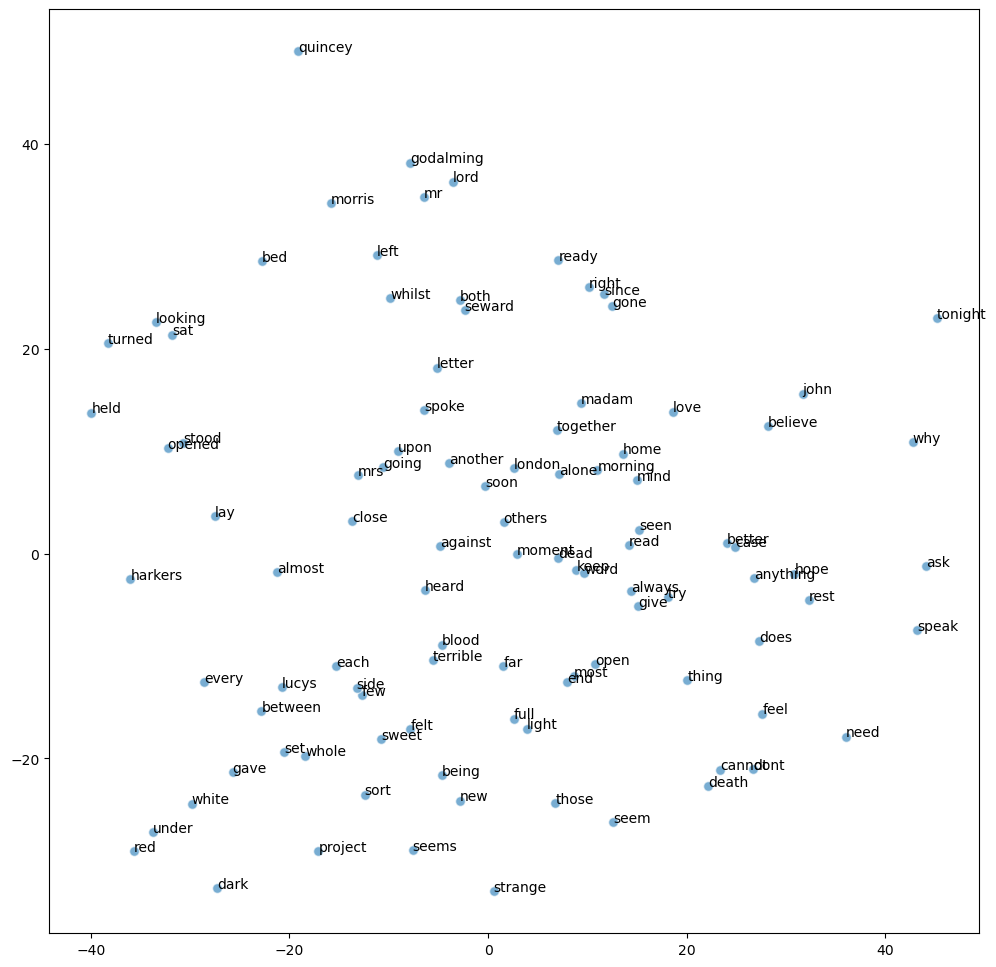

In [84]:
plot_pca(ppmi_matrix, T)

In [85]:
co_matrix_ = compute_cooccurrence_matrix(words, dracula_thematic_words, B)
co_matrix_1 = compute_cooccurrence_matrix(words, T_words_, B)
ppmi_matrix_ = compute_ppmi(co_matrix_)
ppmi_matrix_1 = compute_ppmi(co_matrix_1)

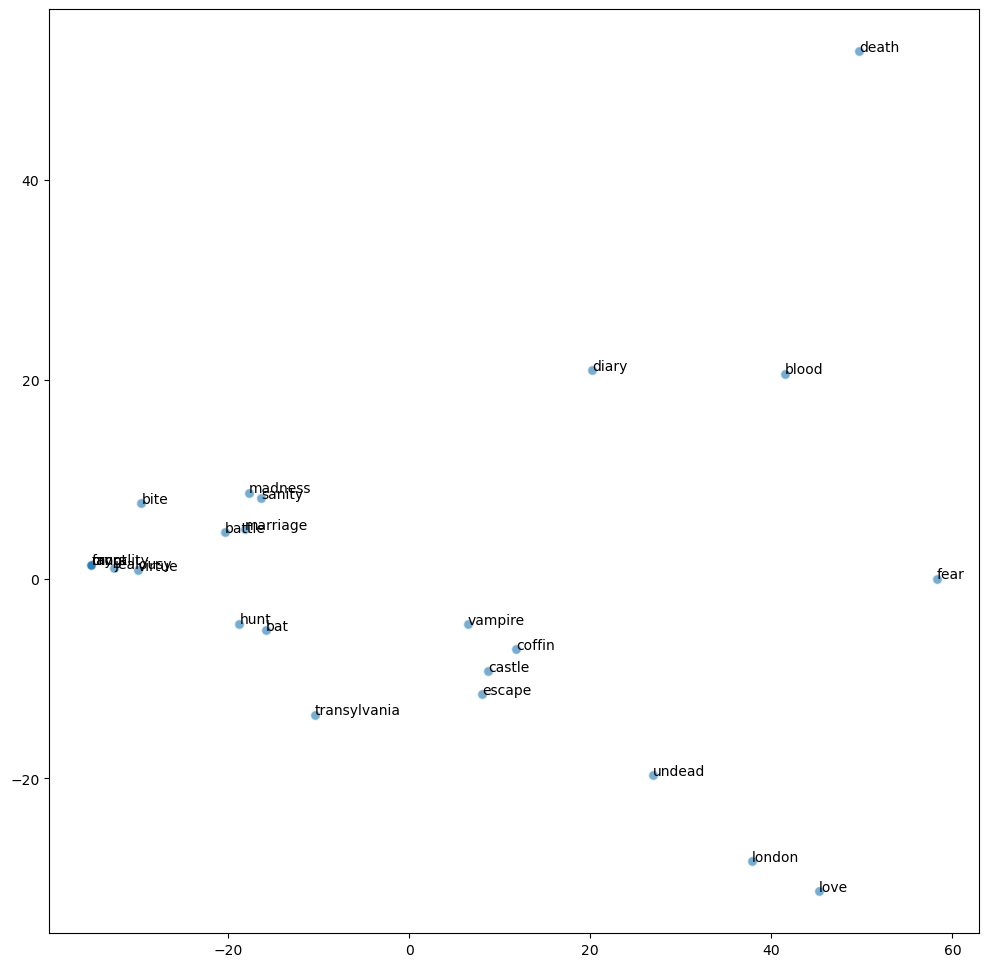

In [86]:
plot_pca(ppmi_matrix_, dracula_thematic_words)

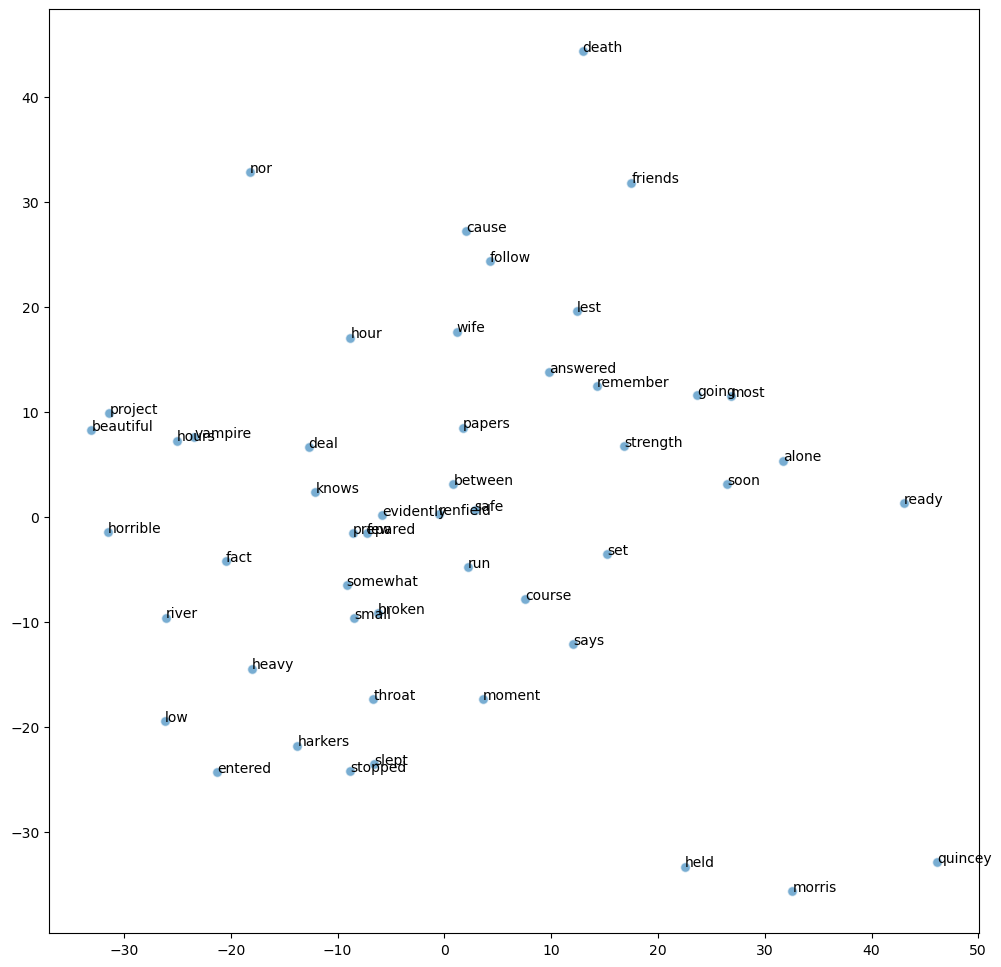

In [87]:
plot_pca(ppmi_matrix_1, T_words_)

In [88]:
T_similarities = compute_most_similar(ppmi_matrix_, dracula_thematic_words)
print(T_similarities)

[('vampire', 'london'), ('blood', 'fear'), ('bite', 'death'), ('undead', 'fear'), ('bat', 'vampire'), ('fang', 'vampire'), ('coffin', 'blood'), ('love', 'fear'), ('death', 'fear'), ('fear', 'death'), ('jealousy', 'hunt'), ('castle', 'love'), ('transylvania', 'castle'), ('london', 'love'), ('crypt', 'vampire'), ('virtue', 'love'), ('morality', 'vampire'), ('marriage', 'blood'), ('hunt', 'love'), ('battle', 'coffin'), ('escape', 'london'), ('madness', 'sanity'), ('sanity', 'madness'), ('diary', 'death')]
